#Sistema de recomendação de artigos
Trabalho de conclusão de curso BI Master - PUC-RJ 

Aluno: Thiago Gavioli

##Importando bibliotecas e datasets

In [ ]:
import pandas as pd
import numpy as np
import pickle
import json
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Função carrega dados
def load_data(user_item_filepath, articles_filepath):
    df = pd.read_csv(user_item_filepath)
    df_content = pd.read_csv(articles_filepath)
    del df['Unnamed: 0']
    del df_content['Unnamed: 0']

    #Insere coluna de frequencia
    df['frequency'] = 1
    return df, df_content

In [ ]:
df, df_content = load_data('user-item-interactions.csv', 'articles_community.csv')

##Data understanding + Data preparation


**df dataset - *User-Item interactions***

In [ ]:
df.head()

,article_id,title,email,frequency
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7,1
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b,1
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074,1
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7,1
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2,1


In [ ]:
print('O df dataset contém {} linhas e {} colunas.'.format(df.shape[0], df.shape[1]))

O df dataset contém 45993 linhas e 4 colunas.


In [ ]:
#verifica se tem null_values
df.isnull().sum()

article_id     0
title          0
email         17
frequency      0
dtype: int64

In [ ]:
df[df['email'].isnull()]

,article_id,title,email,frequency
25131,1016.0,why you should master r (even if it might even...,NaN,1
29758,1393.0,the nurse assignment problem,NaN,1
29759,20.0,working interactively with rstudio and noteboo...,NaN,1
29760,1174.0,breast cancer wisconsin (diagnostic) data set,NaN,1
29761,62.0,data visualization: the importance of excludin...,NaN,1
35264,224.0,"using apply, sapply, lapply in r",NaN,1
35276,961.0,beyond parallelize and collect,NaN,1
35277,268.0,sector correlations shiny app,NaN,1
35278,268.0,sector correlations shiny app,NaN,1
35279,268.0,sector correlations shiny app,NaN,1


Uma vez que são poucos nulos e é difícil atribuir a algum usuário específico, vamos deletar as linhas que contém emails nulos. 

In [ ]:
#Deleta linhas em que a informação de email está nula
df = df.dropna(axis=0, subset=['email'])

In [ ]:
df.isnull().sum()

article_id    0
title         0
email         0
frequency     0
dtype: int64

Tudo ok, dados nulos deletados!

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45976 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   article_id  45976 non-null  float64
 1   title       45976 non-null  object 
 2   email       45976 non-null  object 
 3   frequency   45976 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.8+ MB


**df_content - articles details dataset**

In [ ]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


Uma vez que não utilizaremos esse dataset para modelagem, não será necessário tratar null values.

In [ ]:
#Informações gerais do dataset
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


#Exploratory data analysis

Distribution of how many articles a user interacts with in the dataset

In [ ]:
#Seleciona usuários e quantidade de vezes que cada um interagiu 
int_times_list = list(df.groupby('email')['article_id'].count().sort_values(ascending=False).reset_index()['article_id'])

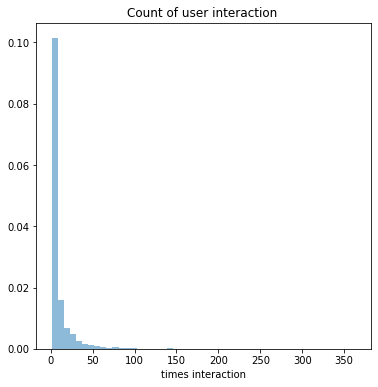

In [ ]:
#Distribuição de vezes que cada usuário interage com artigos 
plt.figure(figsize=(6,6))
plt.hist(int_times_list, bins= 50, histtype='stepfilled', density=True, alpha=.5);
plt.xlabel('times interaction');
plt.title('Count of user interaction ');

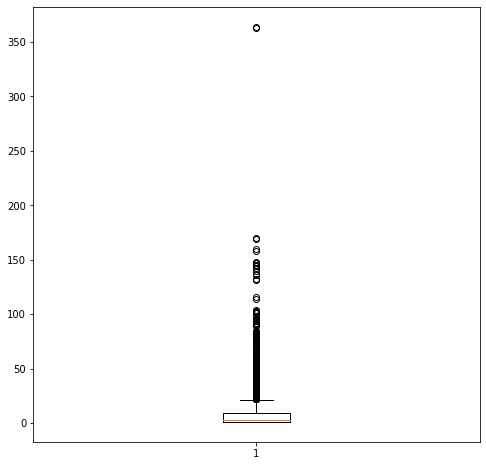

In [ ]:
#Mesma análise acima, porém no gráfico de boxplot
fig = plt.figure(figsize=(8,8))

plt.boxplot(int_times_list)
plt.show()

In [ ]:
#Informações gerais da interação por usuário
df.groupby('email')['article_id'].count().sort_values(ascending=False).reset_index()['article_id'].describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [ ]:
#Número de artigos únicos com interação
len(df['article_id'].unique())

714

In [ ]:
#Número de artigos únicos com ou sem interação - total
len(df_content['article_id'].unique())

1051

In [ ]:
#Número de interações user-artigos registrados
df.shape[0]

45976

**Top 15 artigos mais lidos**

In [ ]:
frequency_art = df.groupby('title')['frequency'].sum().sort_values(ascending=False).reset_index()

Text(0.5, 1.0, 'Top 15 artigos')

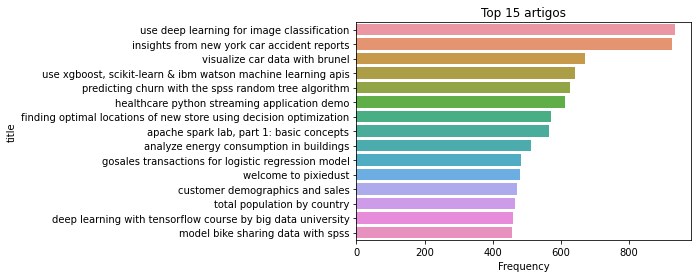

In [ ]:
frequency_art_15 = frequency_art.head(15)

ax = sns.barplot(x='frequency', y='title', data=frequency_art_15)
ax.set_xlabel('Frequency')
ax.set_title('Top 15 artigos')

#Modelling

In [ ]:
# Criar ID's com base no email
def email_mapper(df):
    coded_dict = dict()
    cter = 1
    email_encoded = []

    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter += 1

        email_encoded.append(coded_dict[val])
    return email_encoded

In [ ]:
#Mapeia o email de cada usuário a um novo ID  e deleta a coluna "email"
def map_id(df):
    email_encoded = email_mapper(df)
    del df['email']
    df['user_id'] = email_encoded
    return df

In [ ]:
df = map_id(df)

In [ ]:
df.head()

,article_id,title,frequency,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1,1
1,1314.0,healthcare python streaming application demo,1,2
2,1429.0,use deep learning for image classification,1,3
3,1338.0,ml optimization using cognitive assistant,1,4
4,1276.0,deploy your python model as a restful api,1,5


**Para modelagem, criaremos uma matriz esparsa com informações de usuários nas linhas e artigos consumidos nas colunas**

In [ ]:
# Função para criar a Matriz esparsa
def create_X(df):
    """
    Gera uma matriz esparsa utilizando o dataframe com o consumo por usuário.

    Args:
        df: pandas dataframe

    Returns:
        X: Matriz esparsa
        user_mapper: dict que mapeia usuário id ao índice do usuário
        user_inv_mapper: dict que mapeia o índice ao id do usuário
        artigo_mapper: dict que mapeia id do artigo ao índice do artigo
        artigo_inv_mapper: dict que mapeia o índice do artigo ao id do artigo
    """

    N = df['user_id'].nunique()
    M = df['article_id'].nunique()

    user_mapper = dict(zip(np.unique(df["user_id"]), list(range(N))))
    artigo_mapper = dict(zip(np.unique(df["article_id"]), list(range(M))))

    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["user_id"])))
    artigo_inv_mapper = dict(zip(list(range(M)), np.unique(df["article_id"])))

    user_index = [user_mapper[i] for i in df['user_id']]
    artigo_index = [artigo_mapper[i] for i in df['article_id']]

    X = csr_matrix((df["frequency"], (artigo_index, user_index)), shape=(M, N))

    return X, user_mapper, artigo_mapper, user_inv_mapper, artigo_inv_mapper

In [ ]:
X, user_mapper, artigo_mapper, user_inv_mapper, artigo_inv_mapper = create_X(df)

In [ ]:
#Função que treina o kNN
def train_model(X, k=713, metric='cosine'):
  k+=1
  kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
  kNN.fit(X)

  return kNN

In [ ]:
kNN = train_model(X)

In [ ]:
# Função que encontra os similares
def find_similar_articles(article_id, kNN, k, show_distance=True):
    """
    Encontra k-nearest neighbours para um dado article_id.

    Args:
        article_id: id do artigo de interesse
        X: user-item matriz
        k: número de artigos similares para devolver
        metric: métrica de distância para cálculo no KNN

    Returns:
        lista de k artigos similares
    """
    neighbour_ids = []

    artigo_ind = artigo_mapper[article_id]
    artigo_vec = X[artigo_ind]
    k += 1

    n_distance, neighbour = kNN.kneighbors(artigo_vec, return_distance=show_distance)
    for i in range(0, k):
        n = neighbour.item(i)
        neighbour_ids.append(artigo_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids, n_distance

In [ ]:
#Função que gera as recomendações/similares para cada artigo
def make_recs(df):
    recs = {}

    for id in df['article_id']:
        recs[id] = find_similar_articles(id, kNN, k=15)[0]
    return recs

In [ ]:
recomendations = make_recs(df)

In [ ]:
# Salva o dicionário gerado com as recomendações em um Json File
def save_recs(dict, name='recommendation.json'):
    with open(name, 'w') as json_file:
        json.dump(dict, json_file)
    print('Recomendações salvas.')

In [ ]:
save_recs(recomendations)

Recomendações salvas.


#Results

Vamos gerar 15 recomendados para o artigo de ID igual a 2

In [ ]:
#Output Modelo Knn
article_titles = dict(zip(df['article_id'], df['title']))

article_id = 2

similar_ids = find_similar_articles(article_id, kNN, k=15)[0]
article_title = article_titles[article_id]

print(f"Porque você ouviu \033[1m {article_title} \033[0m, recomendo:")
for i in similar_ids:
    print(article_titles[i], i)

Porque você ouviu  this week in data science (april 18, 2017) , recomendo:
data science platforms are on the rise and ibm is leading the way 524.0
airbnb data for analytics: mallorca reviews 1101.0
experience iot with coursera 29.0
an interview with pythonista katharine jarmul 383.0
deep learning with tensorflow course by big data university 43.0
reducing overplotting in scatterplots 1038.0
this week in data science (april 11, 2017) 448.0
use deep learning for image classification 1429.0
machine learning for the enterprise 800.0
this week in data science (may 30, 2017) 510.0
timeseries data analysis of iot events by using jupyter notebook 12.0
making data cleaning simple with the sparkling.data library 935.0
this week in data science (may 2, 2017) 76.0
flightpredict ii: the sequel  – ibm watson data lab 969.0
apache spark lab, part 3: machine learning 1172.0


O modelo kNN retorna também a distância dos vetores quando o parâmetro "return_distance" é True. Fazendo dessa forma e verificando similares para um artigo encontramos a distância de cada vetor/artigo para o escolhido. 

Abaixo, vamos gerar os recomendados para quem leu o **artigo de ID igual a 2**, e também a distância de cada recomendado para ele. 

Antes, vamos verificar quantos artigos no total foram lidos de acordo com o dataset df. 

In [ ]:
df.article_id.nunique()

714

Uma vez que temos 714 artigos lidos no total, para retornarmos todos os artigos vamos imputar n =  714 - 1 no parâmetro K da função "find_similar_articles". O mesmo n foi inserido no treinamento do modelo kNN. 

In [ ]:
similar_ids, distance = find_similar_articles(2, kNN, k=713)

In [ ]:
#Verificando os 15 primeiros recomendados na ordem
similar_ids[0:15]

[524.0,
 1101.0,
 29.0,
 383.0,
 43.0,
 1038.0,
 448.0,
 1429.0,
 800.0,
 510.0,
 12.0,
 935.0,
 76.0,
 969.0,
 1172.0]

In [ ]:
#Verificando a distância dos 15 primeiros recomendados para o artigo 2 escolhido
distance[0][0:16]

array([0.        , 0.52454269, 0.57142857, 0.59623795, 0.61667406,
       0.64699096, 0.65007289, 0.67972948, 0.69349609, 0.69695424,
       0.69965695, 0.71029679, 0.71428571, 0.72160252, 0.7223624 ,
       0.73180591])

In [ ]:
#Verificando a distância dos 15 últimos recomendados para o artigo 2 escolhido
distance[0][-15:]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])